In [1]:
# https://docs.pymc.io/en/v3/pymc-examples/examples/gaussian_processes/GP-Heteroskedastic.html#Variance-weighted-GP

In [2]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import pymc.sampling.jax
import pytensor.tensor as pt

from scipy.spatial.distance import pdist



/opt/homebrew/Caskroom/miniforge/base/envs/tf/lib/python3.9/site-packages/pymc/sampling/jax.py:39: UserWarning: This module is experimental.
  warnings.warn("This module is experimental.")


In [3]:
SEED = 2020
rng = np.random.default_rng(SEED)
az.style.use("arviz-darkgrid")

<ErrorbarContainer object of 3 artists>

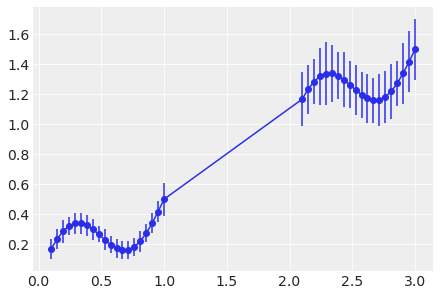

In [4]:
def signal(x):
    return x / 2 + np.sin(2 * np.pi * x) / 5


def noise(y):
    return np.exp(y) / 20


X = np.linspace(0.1, 1, 20)[:, None]
X = np.vstack([X, X + 2])
X_ = X.flatten()
y = signal(X_)
σ_fun = noise(y)

y_err = rng.lognormal(np.log(σ_fun), 0.1)
y_obs = rng.normal(y, y_err, size=(5, len(y)))
y_obs_ = y_obs.T.flatten()
X_obs = np.tile(X.T, (5, 1)).T.reshape(-1, 1)
X_obs_ = X_obs.flatten()
idx = np.tile(np.array([i for i, _ in enumerate(X_)]), (5, 1)).T.flatten()

Xnew = np.linspace(-0.15, 3.25, 100)[:, None]
Xnew_ = Xnew.flatten()
ynew = signal(Xnew)

plt.plot(X, y, "C0o")
plt.errorbar(X_, y, y_err, color="C0")

In [5]:
def get_ℓ_prior(points):
    """Calculates mean and sd for InverseGamma prior on lengthscale"""
    distances = pdist(points[:, None])
    distinct = distances != 0
    ℓ_l = distances[distinct].min() if sum(distinct) > 0 else 0.1
    ℓ_u = distances[distinct].max() if sum(distinct) > 0 else 1
    ℓ_σ = max(0.1, (ℓ_u - ℓ_l) / 6)
    ℓ_μ = ℓ_l + 3 * ℓ_σ
    return ℓ_μ, ℓ_σ


ℓ_μ, ℓ_σ = [stat for stat in get_ℓ_prior(X_)]

In [6]:
def plot_inducing_points(ax):
    yl = ax.get_ylim()
    yu = -np.subtract(*yl) * 0.025 + yl[0]
    ax.plot(Xu, np.full(Xu.shape, yu), "xk", label="Inducing Points")
    ax.legend(loc="upper left")


def get_quantiles(samples, quantiles=[2.5, 50, 97.5]):
    return [np.percentile(samples, p, axis=0) for p in quantiles]


def plot_mean(ax, mean_samples):
    """Plots the median and 95% CI from samples of the mean

    Note that, although each individual GP exhibits a normal distribution at each point
    (by definition), we are sampling from a mixture of GPs defined by the posteriors of
    our hyperparameters. As such, we use percentiles rather than mean +/- stdev to
    represent the spread of predictions from our models.
    """
    l, m, u = get_quantiles(mean_samples)
    ax.plot(Xnew, m, "C0", label="Median")
    ax.fill_between(Xnew_, l, u, facecolor="C0", alpha=0.5, label="95% CI")

    ax.plot(Xnew, ynew, "--k", label="Mean Function")
    ax.plot(X, y, "C1.", label="Observed Means")
    ax.set_title("Mean Behavior")
    ax.legend(loc="upper left")


def plot_var(ax, var_samples):
    """Plots the median and 95% CI from samples of the variance"""
    if var_samples.squeeze().ndim == 1:
        ax.plot(Xnew, var_samples, "C0", label="Median")
    else:
        l, m, u = get_quantiles(var_samples)
        ax.plot(Xnew, m, "C0", label="Median")
        ax.fill_between(Xnew.flatten(), l, u, facecolor="C0", alpha=0.5, label="95% CI")
    ax.plot(Xnew, noise(signal(Xnew_)) ** 2, "--k", label="Noise Function")
    ax.plot(X, y_err ** 2, "C1.", label="Observed Variance")
    ax.set_title("Variance Behavior")
    ax.legend(loc="upper left")


def plot_total(ax, mean_samples, var_samples=None, bootstrap=True, n_boots=100):
    """Plots the overall mean and variance of the aggregate system

    We can represent the overall uncertainty via explicitly sampling the underlying normal
    distributrions (with `bootstrap=True`) or as the mean +/- the standard deviation from
    the Law of Total Variance. For systems with many observations, there will likely be
    little difference, but in cases with few observations and informative priors, plotting
    the percentiles will likely give a more accurate representation.
    """

    if (var_samples is None) or (var_samples.squeeze().ndim == 1):
        samples = mean_samples
        l, m, u = get_quantiles(samples)
        ax.plot(Xnew, m, "C0", label="Median")
    elif bootstrap:
        # Estimate the aggregate behavior using samples from each normal distribution in the posterior
        samples = (
            rng.normal(
                mean_samples.T[:, :, None],
                np.sqrt(var_samples).T[:, :, None],
                (*mean_samples.T.shape, n_boots),
            )
            .reshape(len(Xnew_), -1)
            .T
        )
        l, m, u = get_quantiles(samples)
        ax.plot(Xnew, m, "C0", label="Median")
    else:
        m = mean_samples.mean(axis=0)
        ax.plot(Xnew, m, "C0", label="Mean")
        sd = np.sqrt(mean_samples.var(axis=0) + var_samples.mean(axis=0))
        l, u = m - 2 * sd, m + 2 * sd

    ax.fill_between(Xnew.flatten(), l, u, facecolor="C0", alpha=0.5, label="Total 95% CI")

    ax.plot(Xnew, ynew, "--k", label="Mean Function")
    ax.plot(X_obs, y_obs_, "C1.", label="Observations")
    ax.set_title("Aggregate Behavior")
    ax.legend(loc="upper left")

In [7]:
# with pm.Model() as model_hm:
#     ℓ = pm.InverseGamma("ℓ", mu=ℓ_μ, sigma=ℓ_σ)
#     η = pm.Gamma("η", alpha=2, beta=1)
#     cov = η ** 2 * pm.gp.cov.ExpQuad(input_dim=1, ls=ℓ)

#     gp_hm = pm.gp.Marginal(cov_func=cov)

#     σ = pm.Exponential("σ", lam=1)

#     ml_hm = gp_hm.marginal_likelihood("ml_hm", X=X_obs, y=y_obs_, sigma=σ)

#     # trace_hm = pm.sample(return_inferencedata=True, random_seed=SEED, draws=500, tune=100, chains=2)
#     trace_hm = pymc.sampling.jax.sample_numpyro_nuts(random_seed=SEED, draws=500, tune=100, chains=2)

# with model_hm:
#     mu_pred_hm = gp_hm.conditional("mu_pred_hm", Xnew=Xnew)
#     noisy_pred_hm = gp_hm.conditional("noisy_pred_hm", Xnew=Xnew, pred_noise=True)
#     samples_hm = pm.sample_posterior_predictive(trace_hm, var_names=["mu_pred_hm", "noisy_pred_hm"])

In [8]:
# samples_hm

In [9]:
# reshape_shape = (1000, 100)

In [10]:
# _, axs = plt.subplots(1, 3, figsize=(18, 4))
# mu_samples = samples_hm['posterior_predictive']["mu_pred_hm"]
# noisy_samples = samples_hm['posterior_predictive']["noisy_pred_hm"]
# plot_mean(axs[0], mu_samples.values.reshape(*reshape_shape))
# plot_var(axs[1], noisy_samples.values.reshape(*reshape_shape).var(axis=0))
# plot_total(axs[2], noisy_samples.values.reshape(*reshape_shape))

# Heteroskedastic GP: latent variance model

In [11]:
# with pm.Model() as model_ht:
#     ℓ = pm.InverseGamma("ℓ", mu=ℓ_μ, sigma=ℓ_σ)
#     η = pm.Gamma("η", alpha=2, beta=1)
#     cov = η ** 2 * pm.gp.cov.ExpQuad(input_dim=1, ls=ℓ) + pm.gp.cov.WhiteNoise(sigma=1e-6)

#     gp_ht = pm.gp.Latent(cov_func=cov)
#     μ_f = gp_ht.prior("μ_f", X=X_obs)

#     σ_ℓ = pm.InverseGamma("σ_ℓ", mu=ℓ_μ, sigma=ℓ_σ)
#     σ_η = pm.Gamma("σ_η", alpha=2, beta=1)
#     σ_cov = σ_η ** 2 * pm.gp.cov.ExpQuad(input_dim=1, ls=σ_ℓ) + pm.gp.cov.WhiteNoise(sigma=1e-6)

#     σ_gp = pm.gp.Latent(cov_func=σ_cov)
#     lg_σ_f = σ_gp.prior("lg_σ_f", X=X_obs)
#     σ_f = pm.Deterministic("σ_f", pm.math.exp(lg_σ_f))

#     lik_ht = pm.Normal("lik_ht", mu=μ_f, sigma=σ_f, observed=y_obs_)

#     # trace_ht = pm.sample(target_accept=0.95, return_inferencedata=True, random_seed=SEED, draws=500, tune=100, chains=2)
#     trace_ht = pymc.sampling.jax.sample_numpyro_nuts(target_accept=0.95, random_seed=SEED, draws=500, tune=100, chains=1)

# with model_ht:
#     μ_pred_ht = gp_ht.conditional("μ_pred_ht", Xnew=Xnew)
#     lg_σ_pred_ht = σ_gp.conditional("lg_σ_pred_ht", Xnew=Xnew)
#     samples_ht = pm.sample_posterior_predictive(trace_ht, var_names=["μ_pred_ht", "lg_σ_pred_ht"])


In [12]:
# _, axs = plt.subplots(1, 3, figsize=(18, 4))
# ht_mu_samples = samples_ht['posterior_predictive']["mu_pred_ht"]
# ht_noisy_samples = samples_ht['posterior_predictive']["noisy_pred_ht"]
# plot_mean(axs[0], ht_mu_samples.values.reshape(*reshape_shape))
# plot_var(axs[1], ht_noisy_samples.values.reshape(*reshape_shape).var(axis=0))
# plot_total(axs[2], ht_noisy_samples.values.reshape(*reshape_shape))

# Sparse Heteroskedastic GP

In [13]:
class SparseLatent:
    def __init__(self, cov_func):
        self.cov = cov_func

    def prior(self, name, X, Xu):
        Kuu = self.cov(Xu)
        self.L = pm.gp.util.cholesky(pm.gp.util.stabilize(Kuu))

        self.v = pm.Normal(f"u_rotated_{name}", mu=0.0, sigma=1.0, shape=len(Xu))
        self.u = pm.Deterministic(f"u_{name}", pt.dot(self.L, self.v))

        Kfu = self.cov(X, Xu)
        self.Kuiu = pt.slinalg.solve_triangular(self.L.T, pt.slinalg.solve_triangular(self.L, self.u, lower=True))
        # self.Kuiu = pt.slinalg.solve_upper_triangular(
        #     self.L.T, pt.slinalg.solve_lower_triangular(self.L, self.u)
        # )
        self.mu = pm.Deterministic(f"mu_{name}", pt.dot(Kfu, self.Kuiu))
        return self.mu

    def conditional(self, name, Xnew, Xu):
        Ksu = self.cov(Xnew, Xu)
        mus = pt.dot(Ksu, self.Kuiu)
        # tmp = pt.slinalg.solve_lower_triangular(self.L, Ksu.T)
        tmp = pt.slinalg.solve_triangular(self.L, Ksu.T, lower=True)
        Qss = pt.dot(tmp.T, tmp)  # Qss = pt.dot(pt.dot(Ksu, pt.nlinalg.pinv(Kuu)), Ksu.T)
        Kss = self.cov(Xnew)
        Lss = pm.gp.util.cholesky(pm.gp.util.stabilize(Kss - Qss))
        mu_pred = pm.MvNormal(name, mu=mus, chol=Lss, shape=len(Xnew))
        return mu_pred

In [14]:
# Explicitly specify inducing points by downsampling our input vector
Xu = X[1::2]

with pm.Model() as model_hts:
    ℓ = pm.InverseGamma("ℓ", mu=ℓ_μ, sigma=ℓ_σ)
    η = pm.Gamma("η", alpha=2, beta=1)
    cov = η ** 2 * pm.gp.cov.ExpQuad(input_dim=1, ls=ℓ)

    μ_gp = SparseLatent(cov)
    μ_f = μ_gp.prior("μ", X_obs, Xu)

    σ_ℓ = pm.InverseGamma("σ_ℓ", mu=ℓ_μ, sigma=ℓ_σ)
    σ_η = pm.Gamma("σ_η", alpha=2, beta=1)
    σ_cov = σ_η ** 2 * pm.gp.cov.ExpQuad(input_dim=1, ls=σ_ℓ)

    lg_σ_gp = SparseLatent(σ_cov)
    lg_σ_f = lg_σ_gp.prior("lg_σ_f", X_obs, Xu)
    σ_f = pm.Deterministic("σ_f", pm.math.exp(lg_σ_f))

    lik_hts = pm.Normal("lik_hts", mu=μ_f, sigma=σ_f, observed=y_obs_)
    # trace_hts = pm.sample(target_accept=0.95, return_inferencedata=True, random_seed=SEED)
    trace_hts = pymc.sampling.jax.sample_numpyro_nuts(target_accept=0.95, random_seed=SEED, chains=2)

with model_hts:
    μ_pred = μ_gp.conditional("μ_pred", Xnew, Xu)
    lg_σ_pred = lg_σ_gp.conditional("lg_σ_pred", Xnew, Xu)
    samples_hts = pm.sample_posterior_predictive(trace_hts, var_names=["μ_pred", "lg_σ_pred"])

Compiling...
Compilation time =  0:00:01.554126
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time =  0:03:51.949897
Transforming variables...
Transformation time =  0:00:01.547457


Sampling: [lg_σ_pred, μ_pred]
INFO:pymc:Sampling: [lg_σ_pred, μ_pred]


In [19]:
samples_hts

Inference data with groups:
	> posterior_predictive
	> observed_data

In [25]:
reshape_shape = (2000, 100)

In [10]:
_, axs = plt.subplots(1, 3, figsize=(18, 4))
mu_samples = samples_hm['posterior_predictive']["mu_pred_hm"]
noisy_samples = samples_hm['posterior_predictive']["noisy_pred_hm"]
plot_mean(axs[0], mu_samples.values.reshape(*reshape_shape))
plot_var(axs[1], noisy_samples.values.reshape(*reshape_shape).var(axis=0))
plot_total(axs[2], noisy_samples.values.reshape(*reshape_shape))

In [24]:
μ_samples.values.shape

(2, 1000, 100)

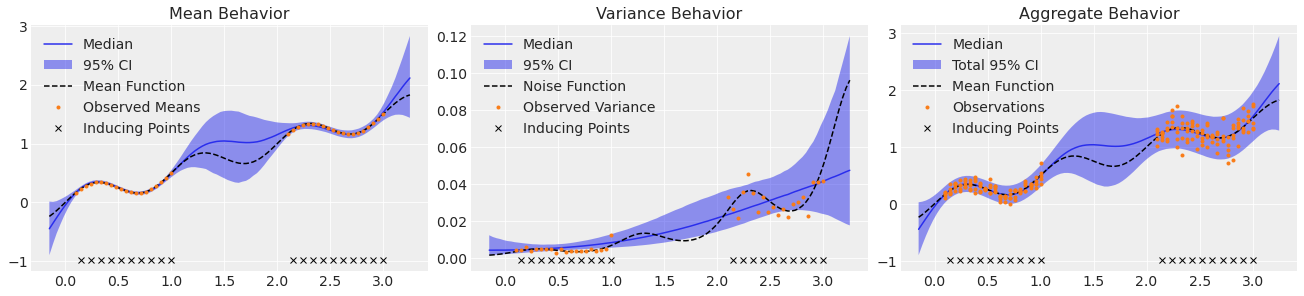

In [27]:
_, axs = plt.subplots(1, 3, figsize=(18, 4))
μ_samples = samples_hts['posterior_predictive']["μ_pred"]
σ_samples = np.exp(samples_hts['posterior_predictive']["lg_σ_pred"])
plot_mean(axs[0], μ_samples.values.reshape(*reshape_shape))
plot_inducing_points(axs[0])
plot_var(axs[1], σ_samples.values.reshape(*reshape_shape) ** 2)
plot_inducing_points(axs[1])
plot_total(axs[2], μ_samples.values.reshape(*reshape_shape), σ_samples.values.reshape(*reshape_shape) ** 2)
plot_inducing_points(axs[2])